# Buka direktori dataset di gdrive

In [242]:
import os
os.chdir('/kaggle/input/capstone-project/drive-download-20240530T171920Z-001')

# Prepocessing

In [243]:
import os

def remove_non_jpg_files(folder_path):
    """Removes all files from a folder that do not have the .jpg extension."""
    for filename in os.listdir(folder_path):
        if not filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)
            os.remove(file_path)


# List of folder paths to process
folder_paths = [
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Healthy',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Miner',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Phoma',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Rust',
]

# Process each folder
for folder in folder_paths:
    remove_non_jpg_files(folder)

In [244]:
#cek label
from pathlib import Path
image_dir = Path('/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [245]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/kaggle/input/capstone-project/drive-download-...,Rust
1,/kaggle/input/capstone-project/drive-download-...,Healthy
2,/kaggle/input/capstone-project/drive-download-...,Phoma
3,/kaggle/input/capstone-project/drive-download-...,Healthy
4,/kaggle/input/capstone-project/drive-download-...,Rust


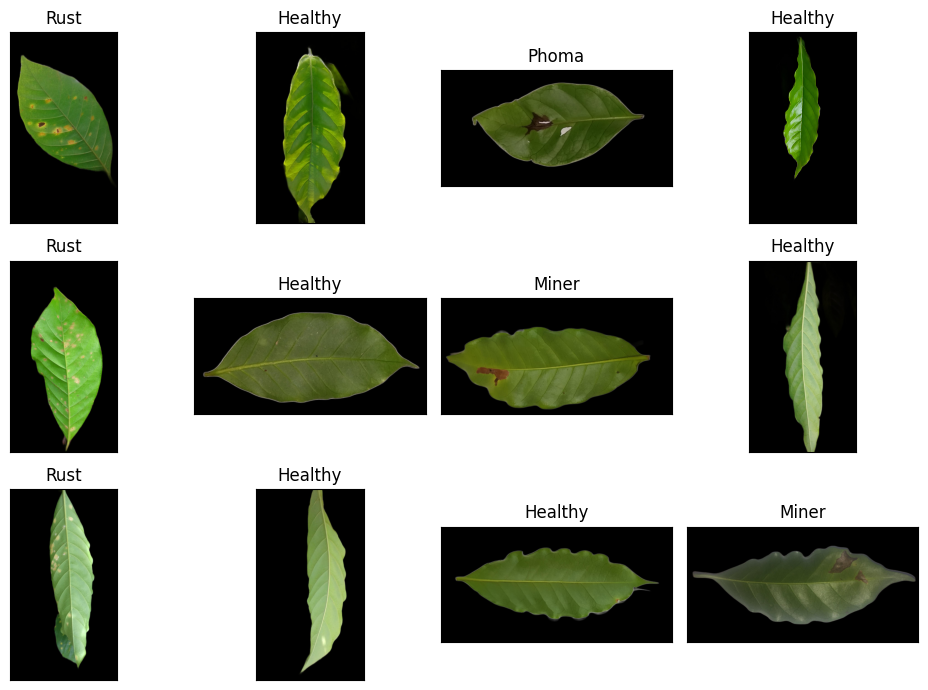

In [246]:
# Display some pictures of the dataset with their labels
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

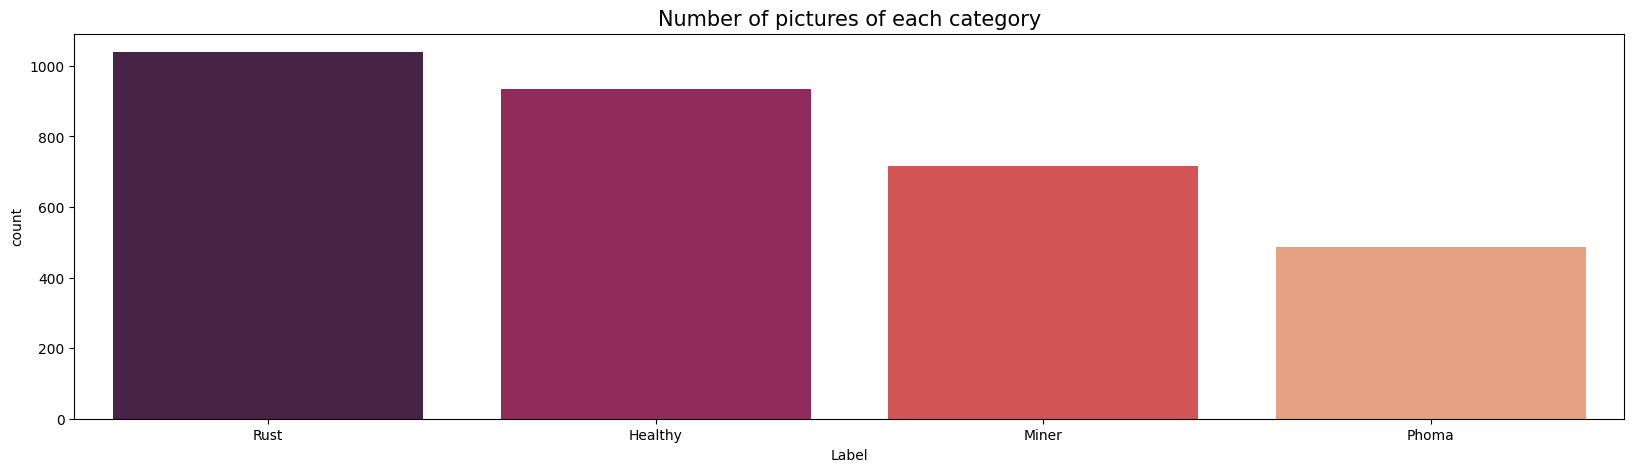

In [247]:

# Display the number of pictures of each category
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [248]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, validasi_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [249]:
import tensorflow as tf #Import tensorflow 

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( # Use tf.keras.preprocessing.image.ImageDataGenerator
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Use tf.keras.preprocessing.image.ImageDataGenerator

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

validasi_data = val_datagen.flow_from_dataframe(dataframe=validasi_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 2541 validated image filenames belonging to 4 classes.
Found 636 validated image filenames belonging to 4 classes.


# Built Mobilenet

In [250]:
# Download the pre-trained weights for ResNet101V2. No top means it excludes the fully connected layer.
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-10-10 16:48:51--  https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 173.194.217.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171317808 (163M) [application/octet-stream]
Saving to: '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

/tmp/resnet101v2_we 100%[===================>] 163.38M   191MB/s    in 0.9s    

2024-10-10 16:48:52 (191 MB/s) - '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5' saved [171317808/171317808]



In [251]:
from keras import Model, Input
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

In [252]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'


# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = ResNet101V2(input_shape = (224, 224, 3),
                                include_top = False,
                                input_tensor=model_input,
                                weights = "imagenet")

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [253]:
pre_trained_model.summary()

Model: "resnet101v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_17[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,626,560 (162.61 MB)

In [254]:
# Choose `conv5_block1_1_conv` as the last layer of your base model
last_layer = pre_trained_model.get_layer('conv4_block6_out')
print('last layer output shape: ', last_layer.output.shape) # Use output.shape instead of output_shape
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 1024)


In [255]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = GlobalAveragePooling2D()(last_output)
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='softmax')(x)

# Append the dense network to the base model
resnet = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
resnet.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_17[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 9,100,292 (34.71 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 8,573,440 (32.71 MB)

In [256]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
callbacks = EarlyStoppingAtMaxAccuracy()

In [257]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan path penyimpanan model
checkpoint_path = '/kaggle/working/resnet.keras'

# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                          save_best_only=True, 
                                          monitor='val_loss', 
                                          mode='min', 
                                          verbose=1)  # Menampilkan pesan saat menyimpan

In [258]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop

# 1. SGD with Momentum
sgd_optimizer = SGD(learning_rate=0.0001, momentum=0.9)
rmsprop_optimizer = RMSprop(learning_rate=0.0001)
adam_optimizer = Adam(learning_rate=0.0001)

# Function to save model and train with different optimizers
def train_with_optimizer(resnet, optimizer, train_data, validasi_data, optimizer_name):
    # Compile the model
    resnet.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    # Train the model
    history = resnet.fit(
        train_data,
        validation_data=validasi_data,
        epochs=15,
        batch_size=32,
        callbacks=([callbacks],[checkpoint_callback]),
        verbose=1
    )
    
    return history

Training with SGD...
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.2422 - loss: 1.4342
Epoch 1: val_loss improved from inf to 1.31753, saving model to /kaggle/working/resnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 92s 952ms/step - accuracy: 0.2427 - loss: 1.4336 - val_accuracy: 0.3664 - val_loss: 1.3175
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.3366 - loss: 1.3291
Epoch 2: val_loss improved from 1.31753 to 1.30666, saving model to /kaggle/working/resnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 73s 840ms/step - accuracy: 0.3365 - loss: 1.3292 - val_accuracy: 0.3396 - val_loss: 1.3067
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.3432 - loss: 1.3315
Epoch 3: val_loss improved from 1.30666 to 1.29733, saving model to /kaggle/working/resnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 73s 839ms/step - accuracy: 0.3432 - loss: 1.3315 - val_accuracy: 0.3538 - val_loss: 1.2973
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.3594 - loss: 1.3228
Epoch 4: val_loss improved

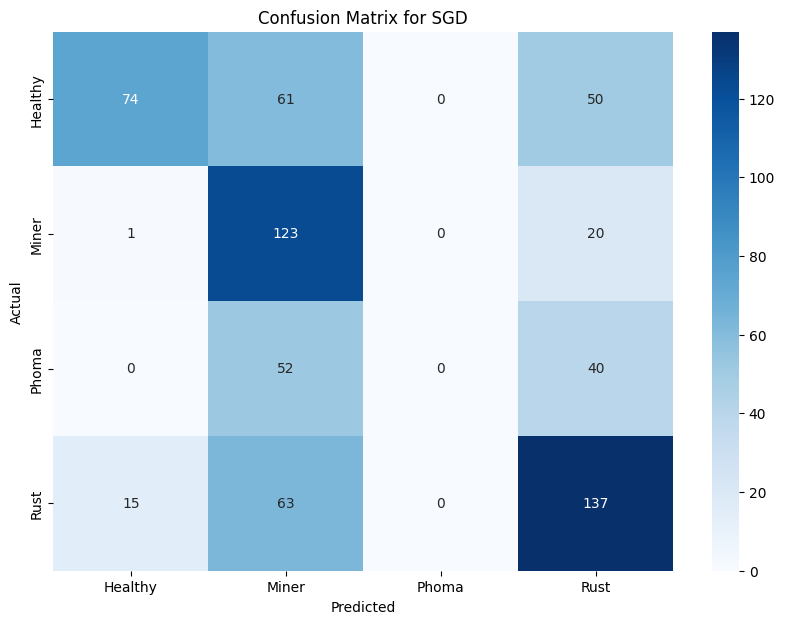

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for SGD:
              precision    recall  f1-score   support

     Healthy       0.82      0.40      0.54       185
       Miner       0.41      0.85      0.56       144
       Phoma       0.00      0.00      0.00        92
        Rust       0.55      0.64      0.59       215

    accuracy                           0.53       636
   macro avg       0.45      0.47      0.42       636
weighted avg       0.52      0.53      0.48       636

Training with RMSprop...
Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.4406 - loss: 1.2495
Epoch 1: val_loss improved from 1.23534 to 1.11635, saving model to /kaggle/working/resnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 882ms/step - accuracy: 0.4406 - loss: 1.2492 - val_accuracy: 0.5676 - val_loss: 1.1164
Epoch 2/15
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.4716 - loss: 1.1511
Epoch 2: val_loss improved from 1.11635 to 1.09378, saving model to /kaggle/working/resnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━

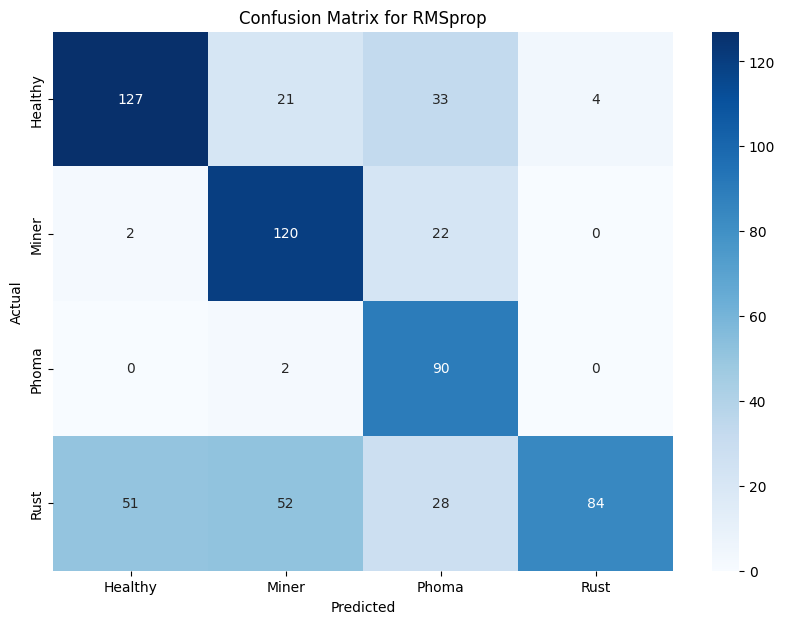

Classification Report for RMSprop:
              precision    recall  f1-score   support

     Healthy       0.71      0.69      0.70       185
       Miner       0.62      0.83      0.71       144
       Phoma       0.52      0.98      0.68        92
        Rust       0.95      0.39      0.55       215

    accuracy                           0.66       636
   macro avg       0.70      0.72      0.66       636
weighted avg       0.74      0.66      0.65       636

Training with Adam...
Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.7085 - loss: 0.7385
Epoch 1: val_loss improved from 0.76649 to 0.75888, saving model to /kaggle/working/resnet.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 87s 907ms/step - accuracy: 0.7084 - loss: 0.7385 - val_accuracy: 0.6745 - val_loss: 0.7589
Epoch 2/15
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6981 - loss: 0.7337
Epoch 2: val_loss improved from 0.75888 to 0.72613, saving model to /kaggle/working/resnet.keras
80/80 ━━━━━━━━━━━━━━━━━━

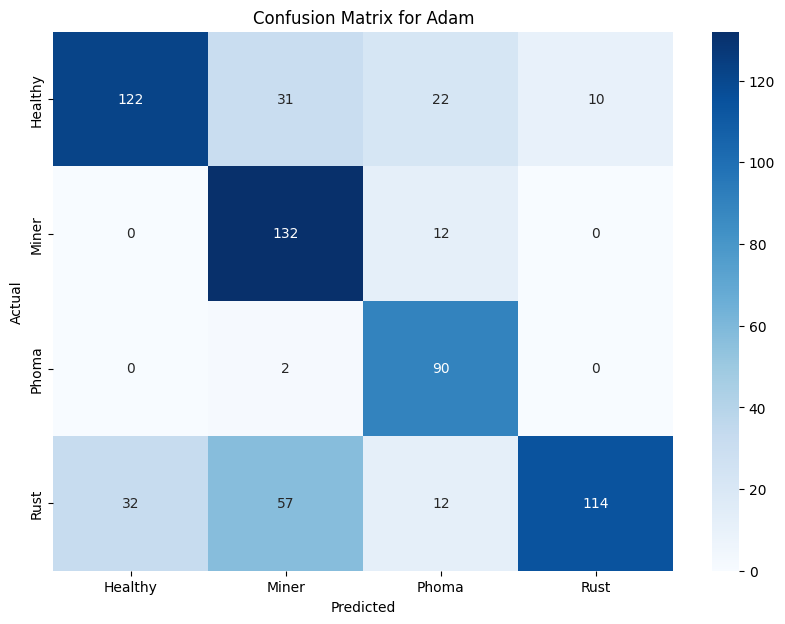

Classification Report for Adam:
              precision    recall  f1-score   support

     Healthy       0.79      0.66      0.72       185
       Miner       0.59      0.92      0.72       144
       Phoma       0.66      0.98      0.79        92
        Rust       0.92      0.53      0.67       215

    accuracy                           0.72       636
   macro avg       0.74      0.77      0.73       636
weighted avg       0.77      0.72      0.71       636



In [259]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, optimizer_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {optimizer_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Function to print classification report
def print_classification_report(y_true, y_pred, classes, optimizer_name):
    report = classification_report(y_true, y_pred, target_names=classes)
    print(f"Classification Report for {optimizer_name}:\n{report}")

# Example usage for training with SGD and RMSprop
optimizers = {
    'SGD': sgd_optimizer,
    'RMSprop': rmsprop_optimizer,
    'Adam': adam_optimizer
}

results = {}
for name, opt in optimizers.items():
    print(f"Training with {name}...")
    history = train_with_optimizer(resnet, opt, train_data, validasi_data, name)
    results[name] = history.history

    # Get predictions and true labels for validation set
    y_pred = np.argmax(resnet.predict(validasi_data), axis=1)
    y_true = validasi_data.classes  # Assuming validasi_data is a generator with .classes attribute

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=validasi_data.class_indices.keys(), optimizer_name=name)

    # Print classification report
    print_classification_report(y_true, y_pred, classes=validasi_data.class_indices.keys(), optimizer_name=name)

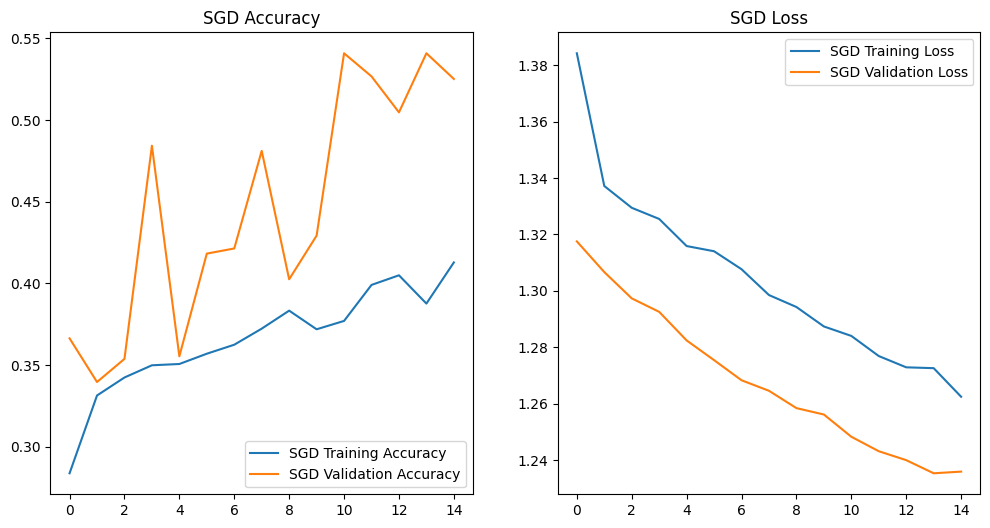

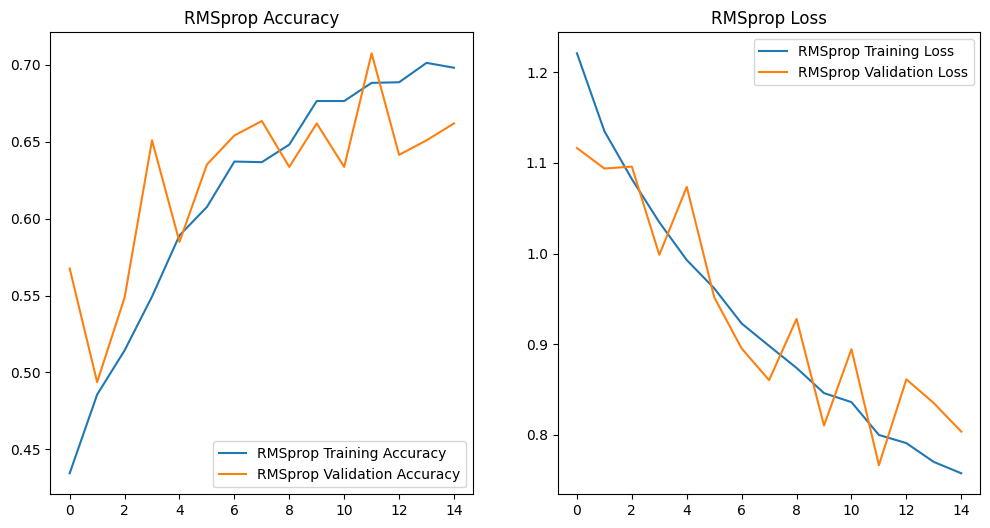

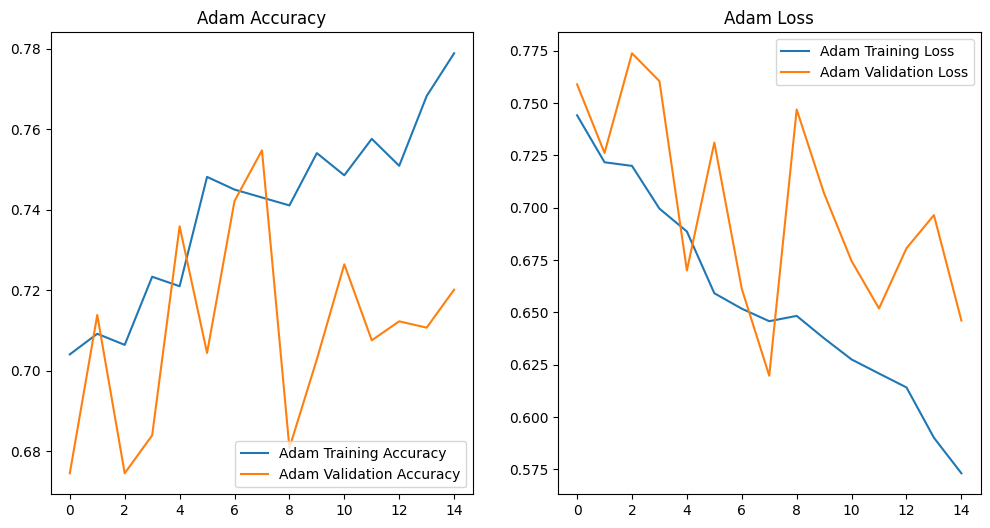

In [260]:
# Plotting function to visualize training results
def plot_training_results(results):
    for optimizer_name, history in results.items():
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
        
        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 6))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label=f'{optimizer_name} Training Accuracy')
        plt.plot(epochs_range, val_acc, label=f'{optimizer_name} Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title(f'{optimizer_name} Accuracy')

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label=f'{optimizer_name} Training Loss')
        plt.plot(epochs_range, val_loss, label=f'{optimizer_name} Validation Loss')
        plt.legend(loc='upper right')
        plt.title(f'{optimizer_name} Loss')

        plt.show()

# Call the function to plot results
plot_training_results(results)

the end

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to evaluate model and generate confusion matrix
def evaluate_model_and_plot_confusion_matrix(mobilenet, validasi_data, class_names):
    # Predict on the validation data
    y_pred = mobilenet.predict(validasi_data)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted classes
    y_true = validasi_data.classes  # True classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report for more metrics (precision, recall, F1-score)
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Example usage after training
class_names = ['Healthy', 'Miner', 'Phoma', 'Rust']  # Replace with actual class names
evaluate_model_and_plot_confusion_matrix(mobilenet, validasi_data, class_names)

In [ ]:

# # Set the training parameters
# callbacks= myCallback()
mobilenet.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history_mobilenet = mobilenet.fit(
                  train_data,
                  batch_size=32,
                  validation_data=validasi_data,
                  epochs=15, callbacks=([callbacks],[checkpoint_callback]))

# Saved Model to .h5

In [ ]:
MODEL_BASE_PATH = "/kaggle/working/"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "mobilenet15epoch.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
mobilenet.save(save_model_path,include_optimizer=False)

In [ ]:
mobilenet.evaluate(validasi_data)

# Plotting Accuration After Training and Test Model

In [ ]:
#plotting
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(6,8), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
#display
display_training_curves(
    history_mobilenet.history['loss'],
    history_mobilenet.history['val_loss'],
    'loss', 211)
display_training_curves(
    history_mobilenet.history['accuracy'],
    history_mobilenet.history['val_accuracy'],
    'accuracy', 212)

In [ ]:
# Predict the label of the test_images
import numpy as np
pred = mobilenet.predict(validasi_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:4]}')

In [ ]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(validasi_df.Label)
print(classification_report(y_test, pred))

In [ ]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(validasi_df.Filepath.iloc[i]))
    ax.set_title(f"True: {validasi_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()